In [ ]:
import networkx as nx
import pandas as pd
from itertools import combinations
import community  # python-louvain
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Step 1: Load CSV
edges_df = pd.read_csv("bipartite_edges.csv")  # Your format: Source, Target, Weight

# Step 2: Build bipartite graph (Cocktail-Ingredient)
B = nx.Graph()
for _, row in edges_df.iterrows():
    cocktail = row['Source'].strip().lower()
    ingredient = row['Target'].strip().lower()
    weight = float(row['Weight'])
    B.add_edge(cocktail, ingredient, weight=weight)

# Step 3: Identify cocktail vs ingredient nodes
# Assuming cocktail nodes only appear as Source
cocktail_nodes = set(edges_df['Source'].str.strip().str.lower())
ingredient_nodes = set(edges_df['Target'].str.strip().str.lower())

# Step 4: Create ingredient co-occurrence graph
ingredient_graph = nx.Graph()

for cocktail in cocktail_nodes:
    ingredients = [nbr for nbr in B.neighbors(cocktail) if nbr in ingredient_nodes]
    for ing1, ing2 in combinations(ingredients, 2):
        if ingredient_graph.has_edge(ing1, ing2):
            ingredient_graph[ing1][ing2]['weight'] += 1
        else:
            ingredient_graph.add_edge(ing1, ing2, weight=1)

# Step 5: Louvain clustering on ingredient graph
ingredient_partition = community.best_partition(ingredient_graph)

# Step 6: Assign cocktails based on their ingredients’ dominant community
cocktail_partition = {}

for cocktail in cocktail_nodes:
    ingredient_neighbors = [nbr for nbr in B.neighbors(cocktail) if nbr in ingredient_partition]
    if ingredient_neighbors:
        communities = [ingredient_partition[ing] for ing in ingredient_neighbors]
        dominant_community = max(set(communities), key=communities.count)
        cocktail_partition[cocktail] = dominant_community

# Step 7: Combine both partitions
combined_partition = {}

for node, comm in ingredient_partition.items():
    combined_partition[node] = comm

for node, comm in cocktail_partition.items():
    combined_partition[node] = comm

# Step 8: Export community assignment to CSV
community_data = [[node, community_id] for node, community_id in combined_partition.items()]
community_df = pd.DataFrame(community_data, columns=["Node", "CommunityID"])
community_df.to_csv("louvain_communities.csv", index=False)

print("✅ Done! Louvain communities saved to louvain_communities.csv")


✅ Done! Louvain communities saved to louvain_communities.csv


""" DEGREE DISTRIBUTIONS """

LINEARLINEAR

In [17]:
# Separate cocktail and ingredient nodes
cocktail_nodes = [n for n in B.nodes() if n in edges_df['Source'].values]
ingredient_nodes = [n for n in B.nodes() if n in edges_df['Target'].values]

# Get degrees
cocktail_degrees = [B.degree(n) for n in cocktail_nodes]
ingredient_degrees = [B.degree(n) for n in ingredient_nodes]


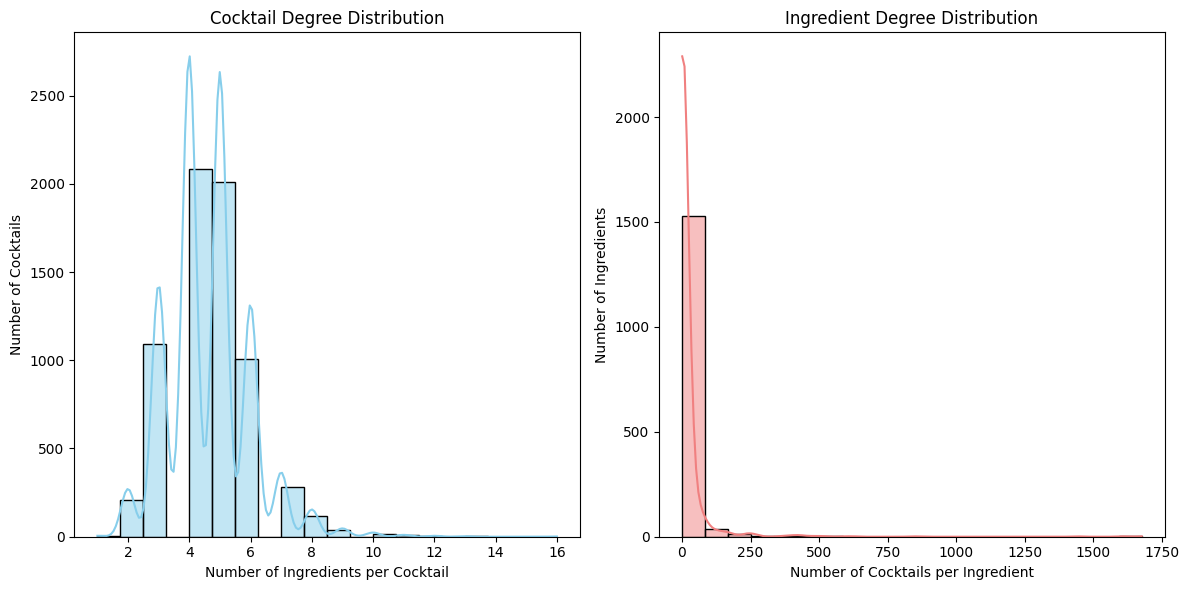

In [18]:
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(cocktail_degrees, bins=20, kde=True, color="skyblue")
plt.title("Cocktail Degree Distribution")
plt.xlabel("Number of Ingredients per Cocktail")
plt.ylabel("Number of Cocktails")

plt.subplot(1, 2, 2)
sns.histplot(ingredient_degrees, bins=20, kde=True, color="lightcoral")
plt.title("Ingredient Degree Distribution")
plt.xlabel("Number of Cocktails per Ingredient")
plt.ylabel("Number of Ingredients")

plt.tight_layout()
plt.show()


LOGLOG

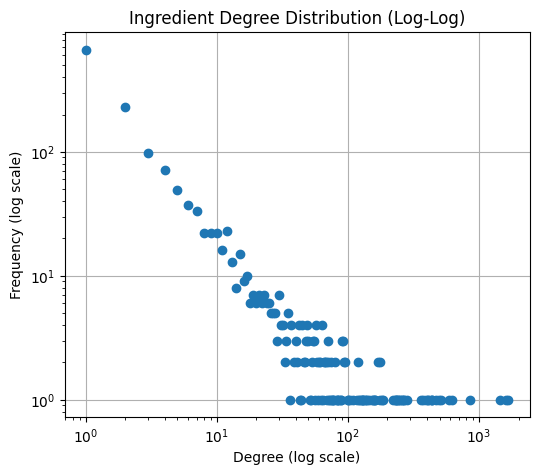

In [19]:
# Degree frequencies for ingredients
ingredient_degree_counts = np.bincount(ingredient_degrees)
ingredient_degrees_nonzero = np.nonzero(ingredient_degree_counts)[0]

plt.figure(figsize=(6, 5))
plt.loglog(ingredient_degrees_nonzero, ingredient_degree_counts[ingredient_degrees_nonzero], marker='o', linestyle='none')
plt.title("Ingredient Degree Distribution (Log-Log)")
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.show()


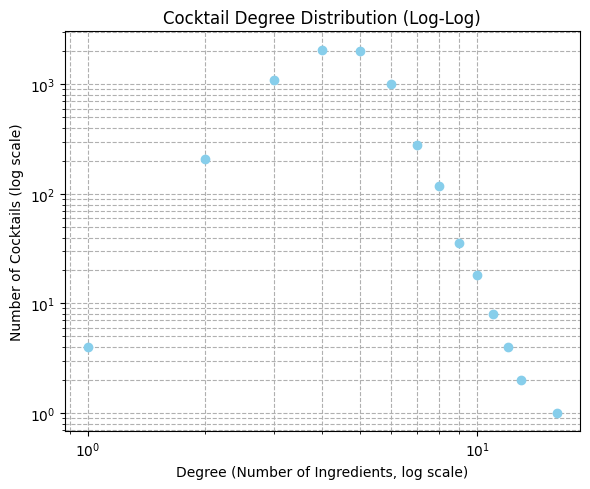

In [20]:
# Cocktails
# Get degree counts for cocktail nodes
cocktail_degree_counts = np.bincount(cocktail_degrees)
cocktail_degrees_nonzero = np.nonzero(cocktail_degree_counts)[0]

plt.figure(figsize=(6, 5))
plt.loglog(cocktail_degrees_nonzero, cocktail_degree_counts[cocktail_degrees_nonzero], marker='o', linestyle='none', color='skyblue')
plt.title("Cocktail Degree Distribution (Log-Log)")
plt.xlabel("Degree (Number of Ingredients, log scale)")
plt.ylabel("Number of Cocktails (log scale)")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


"""AVE SHORTEST PATH"""

In [24]:
if nx.is_connected(B):
    avg_shortest_path_length = nx.average_shortest_path_length(B)
    print(f"Average Shortest Path Length: {avg_shortest_path_length}")
else:
    # For disconnected graph, compute for each connected component
    avg_shortest_path_lengths = []
    for component in nx.connected_components(B):
        subgraph = B.subgraph(component)
        avg_shortest_path_lengths.append(nx.average_shortest_path_length(subgraph))
    
    overall_avg = sum(avg_shortest_path_lengths) / len(avg_shortest_path_lengths)
    print(f"Average Shortest Path Length (for disconnected components): {overall_avg}")


Average Shortest Path Length (for disconnected components): 2.5599598900078613


"""CLUSTERING COEFFICIENT"""

In [25]:
# Clustering coefficient for cocktails
cocktail_subgraph = B.subgraph(cocktail_nodes)
avg_cocktail_clustering = nx.average_clustering(cocktail_subgraph)
print(f"Average Clustering Coefficient for Cocktails: {avg_cocktail_clustering}")

# Clustering coefficient for ingredients
ingredient_subgraph = B.subgraph(ingredient_nodes)
avg_ingredient_clustering = nx.average_clustering(ingredient_subgraph)
print(f"Average Clustering Coefficient for Ingredients: {avg_ingredient_clustering}")


Average Clustering Coefficient for Cocktails: 0.0
Average Clustering Coefficient for Ingredients: 0.0


In [27]:
# Check if the graph has any invalid edges (cocktail-to-cocktail or ingredient-to-ingredient)
invalid_edges = []
for u, v in B.edges:
    if (B.nodes[u].get("Type", "").lower() == "cocktail" and B.nodes[v].get("Type", "").lower() == "cocktail") or \
       (B.nodes[u].get("Type", "").lower() == "ingredient" and B.nodes[v].get("Type", "").lower() == "ingredient"):
        invalid_edges.append((u, v))

if invalid_edges:
    print("Invalid edges found (cocktail-to-cocktail or ingredient-to-ingredient):")
    for edge in invalid_edges:
        print(edge)
else:
    print("No invalid edges found.")


No invalid edges found.


In [29]:
# Use largest connected component (LCC) if your graph is disconnected
if not nx.is_connected(B):
    largest_cc = max(nx.connected_components(B), key=len)
    B_lcc = B.subgraph(largest_cc).copy()
else:
    B_lcc = B

# Average shortest path length
avg_path_length = nx.average_shortest_path_length(B_lcc)
print(f"Average Shortest Path Length: {avg_path_length:.4f}")

Average Shortest Path Length: 3.7866


In [33]:
# Get node type sets
cocktail_nodes = [n for n in B.nodes() if n in edges_df['Source'].values]
ingredient_nodes = [n for n in B.nodes() if n in edges_df['Target'].values]

# Number of nodes and edges
N = len(B)
L = B.size()

# Print the results
print("Number of nodes: ", N)
print("Number of edges: ", L)
print("\nCocktails: ", len(cocktail_nodes))
print("Ingredients: ", len(ingredient_nodes))


# Degrees of nodes
degrees = [B.degree(node) for node in B]

# Minimum and maximum degree
kmin = min(degrees)
kmax = max(degrees)

# Print the results
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation):", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  8474
Number of edges:  31711

Cocktails:  6872
Ingredients:  1602
Number of nodes:  8474
Number of edges:  31711

Average degree:  7.484304932735426
Average degree (alternate calculation): 7.484304932735426

Minimum degree:  1
Maximum degree:  1676


In [53]:
# Using articulation points function to get critical nodes
articulation_points = list(nx.articulation_points(B))

# Get ingredients only
critical_ingredients = [n for n in articulation_points if n in ingredient_nodes]

print(f"Critical Ingredients: {critical_ingredients}")
print(f"Count: {len(critical_ingredients)}")


Critical Ingredients: ['ruby port', 'horse with no name whiskey', 'tonic water', 'baileys irish cream liqueur', 'fever-tree mediterranean tonic water', 'novo fogo barrel-aged cachaça', 'blended scotch whisky', 'aperol aperitivo', 'triple sec liqueur', 'grand marnier liqueur', 'giffard peppermint pastille crème de menthe', 'martini bianco vermouth', 'cherry heering cherry brandy liqueur', 'chilled water', 'italian red bitter liqueur', 'thomas henry soda water', 'lemon juice', 'rutte old simon genever', 'rutte dry gin']
Count: 19


In [54]:
# TEST
test_ingredient = critical_ingredients[0]
B_copy = B.copy()
B_copy.remove_node(test_ingredient)

num_components = nx.number_connected_components(B_copy)
print(f"Removing '{test_ingredient}' results in {num_components} components.")


Removing 'ruby port' results in 3 components.


In [55]:
# ChatGPT generated code starts here
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("glass.csv")

# Preview the data
print("Dataset format for insanity check:")
print(df.head())

# Step 1: Create a crosstab between Glass and Ingredient
crosstab = pd.crosstab(df['Glass'], df['Target'])

print("\n📊 Crosstab (Glass vs Ingredient):")
print(crosstab)

# Step 2: Run Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"\n📈 Chi-squared statistic: {chi2:.4f}")
print(f"📉 P-value: {p:.4f}")
print(f"📐 Degrees of freedom: {dof}")
print("📋 Expected frequencies:")
print(pd.DataFrame(expected, index=crosstab.index, columns=crosstab.columns))

# Step 3: Interpret the result
if p < 0.05:
    print("\n✅ There is a statistically significant relationship between glass type and ingredient usage (p < 0.05).")
else:
    print("\n⚠️ There is no statistically significant relationship between glass type and ingredient usage (p ≥ 0.05).")


Dataset format for insanity check:
           Source                      Target     Weight  \
0  abacaxi ricaço                   pineapple  53.000000   
1  abacaxi ricaço  havana club 3 year old rum   3.043260   
2  abacaxi ricaço                  lime juice   0.760815   
3  abacaxi ricaço          white caster sugar   0.507210   
4           abbey               rutte dry gin   1.521630   

                            Glass  
0  Pineapple shell (frozen) glass  
1  Pineapple shell (frozen) glass  
2  Pineapple shell (frozen) glass  
3  Pineapple shell (frozen) glass  
4                     Coupe glass  

📊 Crosstab (Glass vs Ingredient):
Target                                 'simple' sugar syrup  \
Glass                                                         
Absinthe glass or old-fashioned glass                     1   
Belgium beer glass                                        0   
Boston & shot glass                                       0   
Boston glass                          

In [50]:
# ChatGPT generated code
expected_df = expected_df.replace(0, np.nan)  # Avoid division by zero
rel_diff = (crosstab - expected_df) / expected_df  # relative deviation
print(rel_diff.describe())
print(rel_diff.isna().sum().sum(), "NaN values")
print("Max relative diff:", rel_diff.max().max())
print("Min relative diff:", rel_diff.min().min())

# rel_diff_clipped = rel_diff.clip(lower=-1, upper=3)

# plt.figure(figsize=(14, 8))
# sns.heatmap(rel_diff_clipped, cmap="coolwarm", center=0, linewidths=0.5)
# plt.title("Relative Difference (Clipped at -1 to 3): (Observed - Expected) / Expected")
# plt.xlabel("Ingredient")
# plt.ylabel("Glass Type")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# rel_diff_nan = rel_diff.replace(-1.0, np.nan)
# rel_diff_clipped = rel_diff_nan.clip(lower=-1, upper=3)

# plt.figure(figsize=(14, 8))
# sns.heatmap(rel_diff_clipped, cmap="coolwarm", center=0, linewidths=0.5)
# plt.title("Relative Difference (No -1.0s): (Observed - Expected) / Expected")
# plt.xlabel("Ingredient")
# plt.ylabel("Glass Type")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()



Target  'simple' sugar syrup  *special ingredient no.1  \
count              46.000000                 46.000000   
mean                1.494322                  0.442574   
std                 9.745531                  3.794759   
min                -1.000000                 -1.000000   
25%                -1.000000                 -1.000000   
50%                -1.000000                 -1.000000   
75%                 0.309799                  0.526261   
max                63.981557                 23.754879   

Target  *special ingredient no.2  *special ingredient no.3  \
count                  46.000000                 46.000000   
mean                   -0.467512                 -0.450747   
std                     1.930643                  3.501906   
min                    -1.000000                 -1.000000   
25%                    -1.000000                 -1.000000   
50%                    -1.000000                 -1.000000   
75%                    -1.000000           

In [51]:
import numpy as np

# Count total values and how many are -1.0
total_vals = rel_diff.size
num_neg_ones = (rel_diff == -1.0).sum().sum()
num_non_neg_ones = total_vals - num_neg_ones

print(f"Total cells: {total_vals}")
print(f"Cells with -1.0: {num_neg_ones}")
print(f"Cells with useful values: {num_non_neg_ones}")


Total cells: 73692
Cells with -1.0: 67924
Cells with useful values: 5768


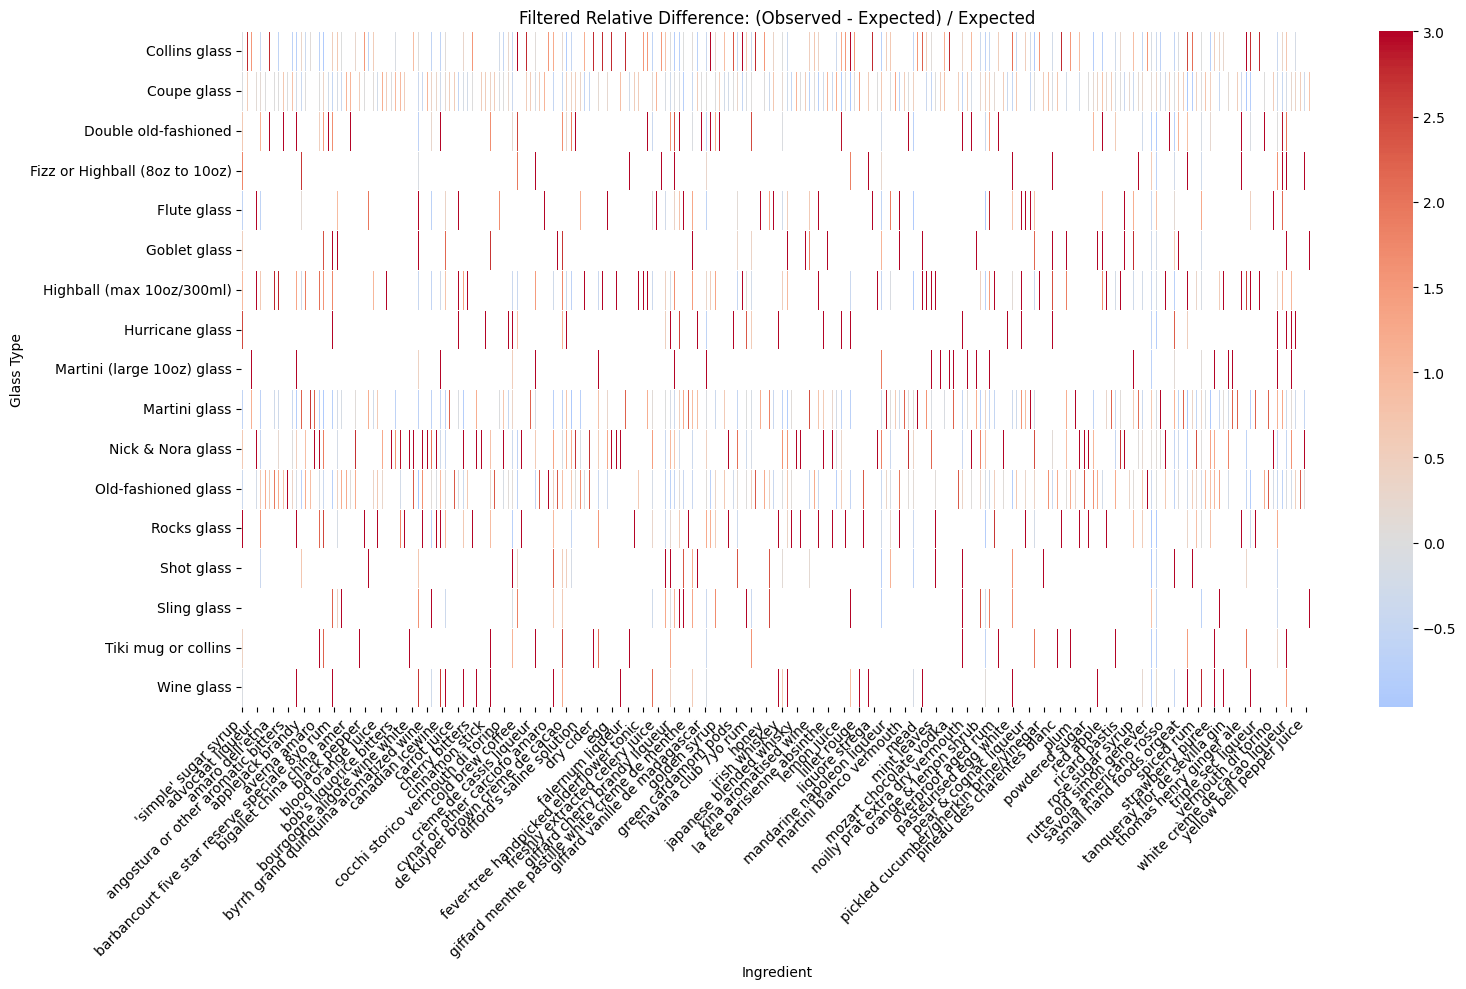

In [52]:
# ChatGPT generated code
# Mask -1.0s for calculation
rel_diff_masked = rel_diff.replace(-1.0, np.nan)

# Drop glass types (rows) where >95% of ingredients are NaN
filtered_rows = rel_diff_masked.dropna(thresh=int(0.05 * rel_diff.shape[1]), axis=0)

# Drop ingredients (cols) where >95% of glass types are NaN
filtered = filtered_rows.dropna(thresh=int(0.05 * rel_diff.shape[0]), axis=1)

# Now clip and plot again
rel_diff_clipped = filtered.clip(lower=-1, upper=3)

plt.figure(figsize=(16, 10))
sns.heatmap(rel_diff_clipped, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Filtered Relative Difference: (Observed - Expected) / Expected")
plt.xlabel("Ingredient")
plt.ylabel("Glass Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [57]:
# ChatGPT generated code
top_rel_diff = rel_diff.replace(-1.0, np.nan).stack().sort_values(ascending=False)
print(top_rel_diff.head(20))  # top 20 most overused ingredients by glass


Glass                               Target                                              
Shot and Beer glass                 belgium dubbel abbey ale                                5284.166667
Tin                                 wyborowa blue vodka rye                                 4529.142857
                                    cranberry & morello cherry puree                        4529.142857
                                    monin caramel syrup                                     2264.071429
Shot and Beer glass                 peroni lager                                            1760.722222
Jam jar glass                       espresso coffee concentrate                             1668.000000
                                    disaronno velvet cream liqueur                          1668.000000
Boston glass                        jägermeister liqueur                                    1377.739130
                                    wkd original blue                          